In [1]:
# import python module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

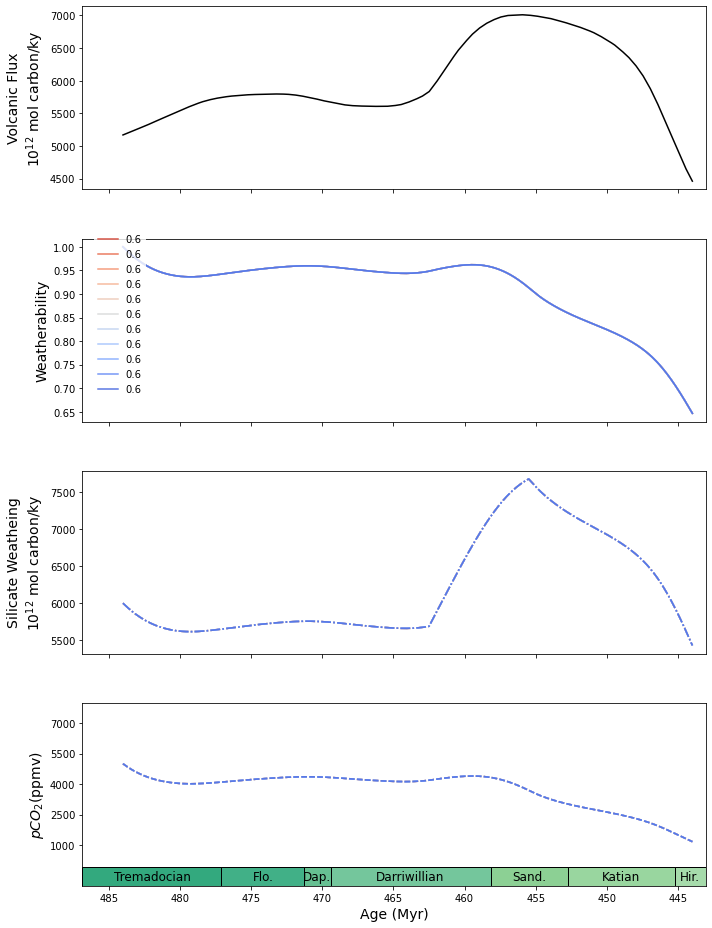

In [14]:
# Import python packages
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

## Phosphorus Cycle
def Mop(Fwp, Fbp):
    '''Mass of phosphate in the oceans
    Fwp : Flux of phosphate into the oceans
    Pbp : flux of phosphate out of the oceans due to burial
    '''
    y = (Fwp - Fbp)
    return y
def Fwp(weatherability, ClimateWeatheringFactor):
    '''
    Flux of phosphate to the oceans (10^12 mol per ky)
    '''
    y = 30 * weatherability * ClimateWeatheringFactor
    return y
def Fbp(Mop, Mop_initial):
    '''Burial of phosphate
    Mop : mass of phosphatein the ocean
    Mop_initial : initial Mop set to 3e3 x 10e12 mol/myr
    '''
    y = 30 * (Mop / Mop_initial)
    return y
def Moc(Fworg, Fvolc, Fborg, Fwsil):
    ''' Mass of Carbon in the atmosphere ocean system'''
    y = (Fworg + Fvolc - Fborg - Fwsil)
    return y

## Carbon Cycle
def Fworg(weatherability, ClimateWeatheringFactor):
    '''Weathering of organic matter'''
    y = 1e4 * weatherability * ClimateWeatheringFactor
    return y
def Fborg(Fbp, CtoP=333):
    '''Burial of organic matter
    Fbp : Flux of phosphate burial
    CtoP : Carbon to Phosphorus ratio (333)
    '''
    y = Fbp * CtoP
    return y
def Fwsil(weatherability, ClimateWeatheringFactor):
    '''Silicate weathering flux'''
    y = 6e3 * weatherability * ClimateWeatheringFactor
    return y

## Strontium Cycle
def Ro(ro, rb, rr, Fwsr, jhsl, Mosr):
    '''Isotopic mass balance of strontium'''
    y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * jhsl) / (Mosr)
    return y
def Rr(time, weatherability):
    '''Sr ratios of riverine flux'''
    if time < 2e4:
        y = 0.7119 - time * 1e-8
    else:
        y = (0.7117 + (weatherability - 1) * 0.7033) / (weatherability)
    return y
def Fwsr(weatherability, climateweatheringfactor):
    '''Riverine Sr flux (continental)'''
    y = 30 * weatherability * climateweatheringfactor
    return y

## PCO2 and Climate Weathering Factor
def pCO2(Moc, Moc_0=1.61e7, pCO2_0=5000):
    '''Partial pressure of CO2'''
    y = (Moc / Moc_0)**2 * pCO2_0
    return y
def CWF(pCO2, p=0.3,pCO2_0=5000):
    '''Climate Weathering Factor'''
    y = (pCO2/pCO2_0)**p
    return y

# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']


def runmod(x_weath, x_cw):
    dt = 1
    # time
    time_min = 0
    time_max = 40000
    time = np.arange(time_min, time_max, dt)
    # array size
    t = len(time)
    age = 484 - time/1e3

    #set time and rate of weatherability change
    rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
    rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
    fall_start = np.where(np.round(age)==453)[0][0]
    # Weatherability
    W = np.ones(t)
    W[rise_start:rise_stop] = np.linspace(1.0, x_weath, (rise_stop-rise_start))
    W[rise_stop:] = x_weath

    # pCO2
    pco2= np.ones(t) # array for pCO2
    pco2_0 = 5000     # initial value of pCO2
    pco2[0] = pco2_0

    # Climate Weathering Factor (CWP)
    cwf = np.ones(t)
    cwf[0] = CWF(pco2[0], p=x_cw)
    
    # resample data to fit our modeling array
    from scipy import interpolate
    f = interpolate.interp1d(ordoseaage, ordosealevel)
    sealevel = f(age)

    # normalize sea level relative to mean
    sl_norm = sealevel / sealevel.mean()
    
    Jh_sl = sl_norm * 2e1
    
    # Initialize Fvolc; also tuning volc flux
    fvolc = np.ones(t)
    fvolc = (sl_norm) * 6000 # initial value = 6000 (Kump and Arthur, 1999)
    
    #Initialize arrays for diff.eq #1
    mop = np.ones(t)  # array for Mop
    mop_0 = 3e3       # initial value of Mop
    mop[0] = mop_0    # assign initial value into array

    fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
    fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

    # Initialize arrays for diff.eq #2
    moc = np.ones(t)  # array for Moc
    moc_0 = 1.61e7    # initial value of Moc
    moc[0] = moc_0    # assign initial value into array

    fworg = Fworg(W, cwf)
    fborg = Fborg(fbp)
    fwsil = Fwsil(W, cwf)
    
    # Initialize Mosr
    mosr = np.ones(t) * 12.4e4

    # Initialize arrays for diff.eq #3
    ro = np.ones(t)
    ro_0 = 0.7091
    ro[0] = ro_0

    rb = np.ones(t) * 0.7033
    fhyd = np.ones(t) * 1.75e-3

    rr = np.ones(t) * 0.7106
    rr[0] = Rr(time[0], W[0])

    fwsr = np.ones(t)
    fwsr[0] = Fwsr(W[0], cwf[0])
    
    # Model implementation
    for i in range(t-1):

        fworg[i+1] = Fworg(W[i], cwf[i])
        fborg[i+1] = Fborg(fbp[i])
        fwsil[i+1] = Fwsil(W[i], cwf[i])
        moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

        pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
        cwf[i+1] = CWF(pco2[i])

        fwp[i+1] = Fwp(W[i], cwf[i])
        fbp[i+1] = Fbp(mop[i], mop_0)
        mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

        rr[i+1] = Rr(time[i], W[i])
        fwsr[i+1] = Fwsr(W[i], cwf[i])
        ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], Jh_sl[i], mosr[i])
    
    results = {'age': age,
               'W': cwf,
               'fwsil' : fwsil,
               'pco2': pco2,
               'fvolc':fvolc,
               'fwsr':fwsr,
               'ro': ro,
               'friv':fwsr}
    return results  

res = {}
ns = 11
# weath = np.linspace(1, 2, ns)
weath = 1.4
pcwf = np.linspace(0.1, 2, ns)
for k in range(len(pcwf)):
    xx = str(int(k))
    res[xx] = runmod(weath, pcwf[k])

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,13))

# Change color cycle to coolwarm
import matplotlib as mpl
from cycler import cycler
color = plt.cm.coolwarm_r(np.linspace(0.1,0.9,ns))

# set axes to use coolwarm color cycle
ax2.set_prop_cycle(cycler('color', color))
ax3.set_prop_cycle(cycler('color', color))
ax4.set_prop_cycle(cycler('color', color))

SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
SrOrdo_2014 = pd.read_csv('../Data/OrdoSr20.csv')

for key in res:
    ax2.plot(res[key]['age'], res[key]['W'], '-', label=str(round(res[key]['W'][-1],1)))
    ax4.plot(res[key]['age'], res[key]['pco2'], '--', label= '$pCO_2$ Model'+key)
    
    ax3.plot(res[key]['age'], res[key]['fwsil'], '-.', label='Silicate Weathering Flux'+key)

ax1.plot(res['0']['age'], res[key]['fvolc'], 'k-')


ax2.set_ylabel('Weatherability', fontsize=14)
ax1.set_ylabel('Volcanic Flux\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.set_ylabel('Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)

ax4.set_ylim(-1000, 8000)
ax4.set_yticks(np.linspace(1000, 7000, 5))

# for ax in (ax1,ax2, ax3, ax4):
#     ax.grid(True)

ax4.set_xlabel('Age (Myr)', fontsize=14)
ax4.set_xlim(486.85, 443.07)

ax2.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1), edgecolor='None')
# ax2.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), edgecolor='None')
# ax3.legend(loc='lower left', bbox_to_anchor=(1.1, 0.1), edgecolor='None')
# ax4.legend(loc='lower left', bbox_to_anchor=( 1.1, 0.1), edgecolor='None')

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax4.get_xaxis_transform()
for ind in chronoDf.index:
    ax4.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind], zorder=9))
    ax4.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12, zorder=9)

plt.tight_layout()
# plt.savefig("../Figures/degassing_CO2_Sr_varyWeatherability_Final.png", dpi=300)
# plt.savefig("../Figures/degassing_CO2_Sr_varyWeatherability_Final.svg")


In [9]:
def dumpow(x):
    res = (4000/5000)**x
    return res

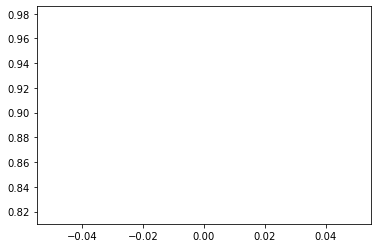

In [10]:
fig, ax = plt.subplots()

xx = np.linspace(0.1, 0.9, 10)

for d in xx:
    resxx = dumpow(d)
    ax.plot(resxx)

In [13]:
xx = np.linspace(0.1, 2, 10)

for i in xx:
    print((4/5)**i)

0.9779327685429285
0.9329324905141485
0.8900029325673684
0.849048809032236
0.80997921887689
0.7727074439456728
0.7371507564810817
0.7032302355027339
0.6708705916357862
0.6400000000000001
